In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

In [3]:
import torch
from torch.utils.data import DataLoader
from unsloth import FastLanguageModel

from src.mslm.models import Imitator, PositionalEncoding
from src.mslm.dataloader import KeypointDataset, SignDataLoader, collate_fn
from src.mslm.utils.llm_tools import Tools

from src.mslm.inference import MultimodalSignLM

In [4]:
modelParameters = {
    "input_size": 543*2,
    "output_size": 3072,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 1000,
    "logIntervals": 20,
    "checkpointIntervals": 5,
    "batchSize": 32,
    "frameClips": 15 * 35,
    "train_ratio": 0.8,
    "validation_ratio": 0.2
}

In [5]:
DataPath = os.path.join(os.path.dirname(os.getcwd()), os.pardir, "data", "dataset2")
h5File = os.path.join(DataPath, "keypoints.h5")
csvFile = os.path.join(DataPath, "meta.csv")

In [6]:
LOG = False
tools = Tools()
keypointReader = KeypointDataset(h5Path=h5File, labelsCSV=csvFile, max_seq_len=modelParameters["frameClips"])[0]
dataset = SignDataLoader(tools.tokenizer, [keypointReader], modelParameters["device"])
test_dataloader = DataLoader(dataset, batch_size=modelParameters["batchSize"], shuffle=True, collate_fn=collate_fn)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 15.576 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [7]:
del tools

In [8]:
import gc
def clean():
    while True:
        torch.cuda.empty_cache()
        if gc.collect() == 0: break
clean()

In [9]:
text_test =keypointReader[1]
text_test

'cerrar las canillas durante el cepillado de dientes, de lavarse las manos, de la cara, de afeitarse, de lavar los platos, pelar papas, en lugar de dejar correr el agua.'

In [10]:
embed_test = dataset[0][1]
embed_test

tensor([128000,  24913,    277,   5252,    649,  34344,  30331,    658,  63190,
           484,   2172,    409,    294,  27335,     11,    409,  30583,   2648,
          5252,  97349,     11,    409,   1208,  48034,     11,    409,    264,
         62221,   2648,     11,    409,  30583,    277,   2537,    628,  14357,
            11,  12077,    277,  26365,    300,     11,    665,  35000,    409,
         81499,   1867,  38149,    658,  56562,     13, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004, 128004,
        128004, 128004, 128004, 128004, 

## Get log from text

In [40]:
llama_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct",
    max_seq_length=4096,
    dtype=None,
    load_in_4bit=True,
)

==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 15.576 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [12]:
with torch.no_grad():
    input_ids = tokenizer.encode(text_test, return_tensors="pt").to(modelParameters["device"])
    # fill input_ids with padding token 128004
    input_ids = torch.cat([input_ids, torch.full((1, 128 - input_ids.shape[1]), 128004).to(modelParameters["device"])], dim=1)
    logits = llama_model(input_ids)

In [13]:
text_logits = logits.logits
text_logits.shape

torch.Size([1, 128, 128256])

In [14]:
del llama_model, tokenizer
clean()

In [15]:
imitator_model = Imitator(input_size=modelParameters["input_size"], T_size=modelParameters["frameClips"], output_size=modelParameters["output_size"]).to(modelParameters["device"])

In [17]:
!unzip ../outputs/checkpoint/model.pt -d ../outputs/checkpoint/model_unpacked

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Archive:  ../outputs/checkpoint/model.pt
 extracting: ../outputs/checkpoint/model_unpacked/model/data.pkl  
 extracting: ../outputs/checkpoint/model_unpacked/model/byteorder  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/0  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/1  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/10  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/11  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/12  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/13  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/14  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/15  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/16  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/17  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/18  
 extracting: ../outputs/checkpoint/model_unpacked/model/data/19  
 extracting: ../outputs/checkpoint

In [58]:
import sys
import types
import torch

dummy_module = types.ModuleType("src.train.Imitator")
pe_dummy = types.ModuleType("src.train.PositionalEncoding")

class DummyImitator(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        # x -> [batch_size, T, input_size]
        B, T, D, C = x.shape
        x = x.view(B, T,  D * C)
        x = F.relu(self.linear(x))
        x = self.norm1(x)

        x = self.pe(x)
        x = self.transformer(x)

        x = x.transpose(1, 2)    # [B, hidden, 525]
        x = self.temporal_adjuster(x)  # [B, hidden, 128]
        x = x.transpose(1, 2)
        
        x = self.linear_out(x)
        
        # x = F.relu(self.linear_out(x))

        # x = x.transpose(1, 2)
        # x = F.relu(self.pooling(x))
        # x = x.transpose(1, 2)

        return x

dummy_module.Imitator = DummyImitator
pe_dummy.PositionalEncoding = PositionalEncoding

sys.modules["src.train.Imitator"] = dummy_module
sys.modules["src.train.PositionalEncoding"] = pe_dummy

checkpoint_path = "/home/giorgio6846/Code/Sign-AI/Sign-Multimodal-Language-Model/outputs/model/checkpoints/35/1/15/model.pt"
model = torch.load(checkpoint_path, map_location='cpu', weights_only=False)

print("✅ Modelo cargado exitosamente")


✅ Modelo cargado exitosamente


In [16]:
torch.serialization.add_safe_globals([Imitator])
# checkpoint_path = "../../outputs/checkpoints/finetuning/41/1/1/5/checkpoint.pth"
# checkpoint_path = "/home/giorgio6846/Code/Sign-AI/Sign-chris/scripts/outputs/checkpoints/finetuning/42/1/1/5/checkpoint.pth"
checkpoint_path = "/home/giorgio6846/Code/Sign-AI/Sign-Multimodal-Language-Model/outputs/model/checkpoints/35/1/15/model.pt"

state_dict = torch.load(checkpoint_path, weights_only=False)

ModuleNotFoundError: No module named 'src.train'

In [ ]:
from collections import OrderedDict

In [ ]:
def load_weights(model, state_dict, rename=True):
    if rename:
        new_state_dict = OrderedDict()

        for k, v in state_dict.items():
            new_key = k.replace('_orig_mod.', '')
            new_state_dict[new_key] = v

    model.load_state_dict(state_dict)
    return model

In [ ]:
imitator_model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Imitator:
	Missing key(s) in state_dict: "stgcn.blocks.0.spatial_conv.weight", "stgcn.blocks.0.spatial_conv.bias", "stgcn.blocks.0.temp_conv.weight", "stgcn.blocks.0.temp_conv.bias", "stgcn.blocks.0.norm.weight", "stgcn.blocks.0.norm.bias", "stgcn.blocks.0.norm.running_mean", "stgcn.blocks.0.norm.running_var", "stgcn.blocks.1.spatial_conv.weight", "stgcn.blocks.1.spatial_conv.bias", "stgcn.blocks.1.temp_conv.weight", "stgcn.blocks.1.temp_conv.bias", "stgcn.blocks.1.norm.weight", "stgcn.blocks.1.norm.bias", "stgcn.blocks.1.norm.running_mean", "stgcn.blocks.1.norm.running_var". 
	Unexpected key(s) in state_dict: "linear.weight", "linear.bias", "norm1.weight", "norm1.bias", "pe.pe", "transformer.layers.0.self_attn.in_proj_weight", "transformer.layers.0.self_attn.in_proj_bias", "transformer.layers.0.self_attn.out_proj.weight", "transformer.layers.0.self_attn.out_proj.bias", "transformer.layers.0.linear1.weight", "transformer.layers.0.linear1.bias", "transformer.layers.0.linear2.weight", "transformer.layers.0.linear2.bias", "transformer.layers.0.norm1.weight", "transformer.layers.0.norm1.bias", "transformer.layers.0.norm2.weight", "transformer.layers.0.norm2.bias", "transformer.layers.1.self_attn.in_proj_weight", "transformer.layers.1.self_attn.in_proj_bias", "transformer.layers.1.self_attn.out_proj.weight", "transformer.layers.1.self_attn.out_proj.bias", "transformer.layers.1.linear1.weight", "transformer.layers.1.linear1.bias", "transformer.layers.1.linear2.weight", "transformer.layers.1.linear2.bias", "transformer.layers.1.norm1.weight", "transformer.layers.1.norm1.bias", "transformer.layers.1.norm2.weight", "transformer.layers.1.norm2.bias", "transformer.layers.2.self_attn.in_proj_weight", "transformer.layers.2.self_attn.in_proj_bias", "transformer.layers.2.self_attn.out_proj.weight", "transformer.layers.2.self_attn.out_proj.bias", "transformer.layers.2.linear1.weight", "transformer.layers.2.linear1.bias", "transformer.layers.2.linear2.weight", "transformer.layers.2.linear2.bias", "transformer.layers.2.norm1.weight", "transformer.layers.2.norm1.bias", "transformer.layers.2.norm2.weight", "transformer.layers.2.norm2.bias", "transformer.layers.3.self_attn.in_proj_weight", "transformer.layers.3.self_attn.in_proj_bias", "transformer.layers.3.self_attn.out_proj.weight", "transformer.layers.3.self_attn.out_proj.bias", "transformer.layers.3.linear1.weight", "transformer.layers.3.linear1.bias", "transformer.layers.3.linear2.weight", "transformer.layers.3.linear2.bias", "transformer.layers.3.norm1.weight", "transformer.layers.3.norm1.bias", "transformer.layers.3.norm2.weight", "transformer.layers.3.norm2.bias", "transformer.layers.4.self_attn.in_proj_weight", "transformer.layers.4.self_attn.in_proj_bias", "transformer.layers.4.self_attn.out_proj.weight", "transformer.layers.4.self_attn.out_proj.bias", "transformer.layers.4.linear1.weight", "transformer.layers.4.linear1.bias", "transformer.layers.4.linear2.weight", "transformer.layers.4.linear2.bias", "transformer.layers.4.norm1.weight", "transformer.layers.4.norm1.bias", "transformer.layers.4.norm2.weight", "transformer.layers.4.norm2.bias", "transformer.layers.5.self_attn.in_proj_weight", "transformer.layers.5.self_attn.in_proj_bias", "transformer.layers.5.self_attn.out_proj.weight", "transformer.layers.5.self_attn.out_proj.bias", "transformer.layers.5.linear1.weight", "transformer.layers.5.linear1.bias", "transformer.layers.5.linear2.weight", "transformer.layers.5.linear2.bias", "transformer.layers.5.norm1.weight", "transformer.layers.5.norm1.bias", "transformer.layers.5.norm2.weight", "transformer.layers.5.norm2.bias", "transformer.layers.6.self_attn.in_proj_weight", "transformer.layers.6.self_attn.in_proj_bias", "transformer.layers.6.self_attn.out_proj.weight", "transformer.layers.6.self_attn.out_proj.bias", "transformer.layers.6.linear1.weight", "transformer.layers.6.linear1.bias", "transformer.layers.6.linear2.weight", "transformer.layers.6.linear2.bias", "transformer.layers.6.norm1.weight", "transformer.layers.6.norm1.bias", "transformer.layers.6.norm2.weight", "transformer.layers.6.norm2.bias", "transformer.layers.7.self_attn.in_proj_weight", "transformer.layers.7.self_attn.in_proj_bias", "transformer.layers.7.self_attn.out_proj.weight", "transformer.layers.7.self_attn.out_proj.bias", "transformer.layers.7.linear1.weight", "transformer.layers.7.linear1.bias", "transformer.layers.7.linear2.weight", "transformer.layers.7.linear2.bias", "transformer.layers.7.norm1.weight", "transformer.layers.7.norm1.bias", "transformer.layers.7.norm2.weight", "transformer.layers.7.norm2.bias", "transformer.layers.8.self_attn.in_proj_weight", "transformer.layers.8.self_attn.in_proj_bias", "transformer.layers.8.self_attn.out_proj.weight", "transformer.layers.8.self_attn.out_proj.bias", "transformer.layers.8.linear1.weight", "transformer.layers.8.linear1.bias", "transformer.layers.8.linear2.weight", "transformer.layers.8.linear2.bias", "transformer.layers.8.norm1.weight", "transformer.layers.8.norm1.bias", "transformer.layers.8.norm2.weight", "transformer.layers.8.norm2.bias", "transformer.layers.9.self_attn.in_proj_weight", "transformer.layers.9.self_attn.in_proj_bias", "transformer.layers.9.self_attn.out_proj.weight", "transformer.layers.9.self_attn.out_proj.bias", "transformer.layers.9.linear1.weight", "transformer.layers.9.linear1.bias", "transformer.layers.9.linear2.weight", "transformer.layers.9.linear2.bias", "transformer.layers.9.norm1.weight", "transformer.layers.9.norm1.bias", "transformer.layers.9.norm2.weight", "transformer.layers.9.norm2.bias", "transformer.layers.10.self_attn.in_proj_weight", "transformer.layers.10.self_attn.in_proj_bias", "transformer.layers.10.self_attn.out_proj.weight", "transformer.layers.10.self_attn.out_proj.bias", "transformer.layers.10.linear1.weight", "transformer.layers.10.linear1.bias", "transformer.layers.10.linear2.weight", "transformer.layers.10.linear2.bias", "transformer.layers.10.norm1.weight", "transformer.layers.10.norm1.bias", "transformer.layers.10.norm2.weight", "transformer.layers.10.norm2.bias", "transformer.layers.11.self_attn.in_proj_weight", "transformer.layers.11.self_attn.in_proj_bias", "transformer.layers.11.self_attn.out_proj.weight", "transformer.layers.11.self_attn.out_proj.bias", "transformer.layers.11.linear1.weight", "transformer.layers.11.linear1.bias", "transformer.layers.11.linear2.weight", "transformer.layers.11.linear2.bias", "transformer.layers.11.norm1.weight", "transformer.layers.11.norm1.bias", "transformer.layers.11.norm2.weight", "transformer.layers.11.norm2.bias". 
	size mismatch for linear_out.weight: copying a param with shape torch.Size([3072, 1024]) from checkpoint, the shape in current model is torch.Size([3072, 3072]).

In [59]:
imitator_model = model.to("cuda")

## Graph probability distributtion between imitator logits and text logits

In [38]:
import matplotlib.pyplot as plt

In [41]:
llama_model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,)

In [42]:
llama_embed_layer = llama_model.get_input_embeddings()
lm_head = llama_model.lm_head.to("cuda")

In [43]:
del llama_model, tokenizer
clean()

In [60]:
imitator_model.forward

<function torch.nn.modules.module.Module._wrapped_call_impl(*args, **kwargs)>

In [61]:
imitator_model.eval()

with torch.no_grad():
    for keypoints, input_ids in test_dataloader:
        keypoints = keypoints.to("cuda")
        input_ids = input_ids.to("cuda")

        pred_embeds = imitator_model(keypoints).to("cuda")
        pred_embeds = pred_embeds.to(dtype=torch.bfloat16)        
        
        pred_logits = lm_head(pred_embeds)


In [52]:
import torch.nn.functional as F

In [62]:
F.softmax(text_logits, dim=-1)

tensor([[[4.6730e-05, 3.5048e-05, 1.3794e-02,  ..., 1.3039e-06,
          1.3039e-06, 1.3039e-06],
         [2.6345e-05, 3.4332e-05, 4.2677e-05,  ..., 7.1712e-08,
          7.1712e-08, 7.1712e-08],
         [8.9407e-06, 1.2040e-05, 1.4603e-05,  ..., 2.1420e-08,
          2.1420e-08, 2.1420e-08],
         ...,
         [1.0478e-15, 3.6637e-15, 1.9096e-14,  ..., 6.4727e-08,
          6.4727e-08, 6.4727e-08],
         [1.2768e-15, 5.0515e-15, 2.2204e-14,  ..., 6.3330e-08,
          6.3330e-08, 6.3330e-08],
         [1.5890e-15, 6.4670e-15, 2.5202e-14,  ..., 6.3330e-08,
          6.3330e-08, 6.3330e-08]]], device='cuda:0', dtype=torch.bfloat16)

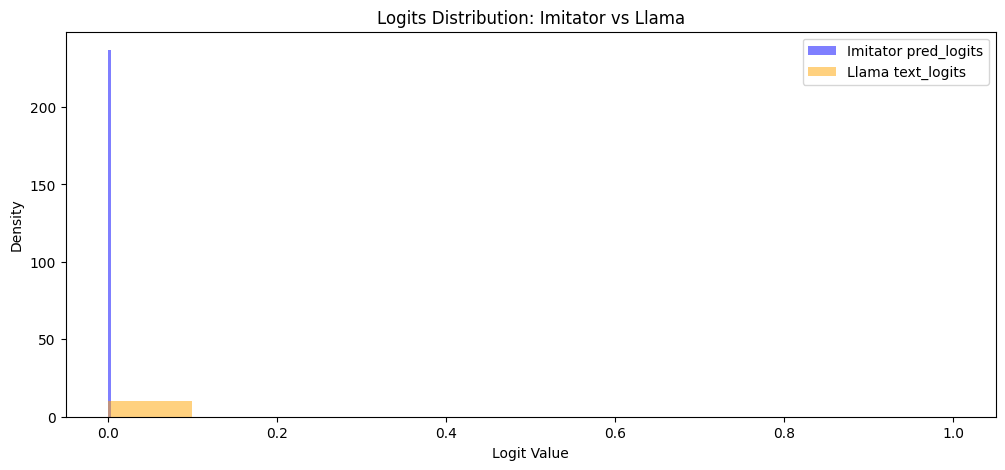

In [ ]:
"""plt.figure(figsize=(12, 5))

# Flatten logits for histogram
pred_logits_flat = F.softmax(pred_logits, dim=-1).flatten().cpu().float().numpy()
text_logits_flat = F.softmax(text_logits, dim=-1).flatten().cpu().float().numpy()

plt.hist(pred_logits_flat, alpha=0.5, label='Imitator pred_logits', color='blue', density=True)
plt.hist(text_logits_flat, alpha=0.5, label='Llama text_logits', color='orange', density=True)

plt.title("Logits Distribution: Imitator vs Llama")
plt.xlabel("Logit Value")
plt.ylabel("Density")
plt.legend()
plt.show()"""

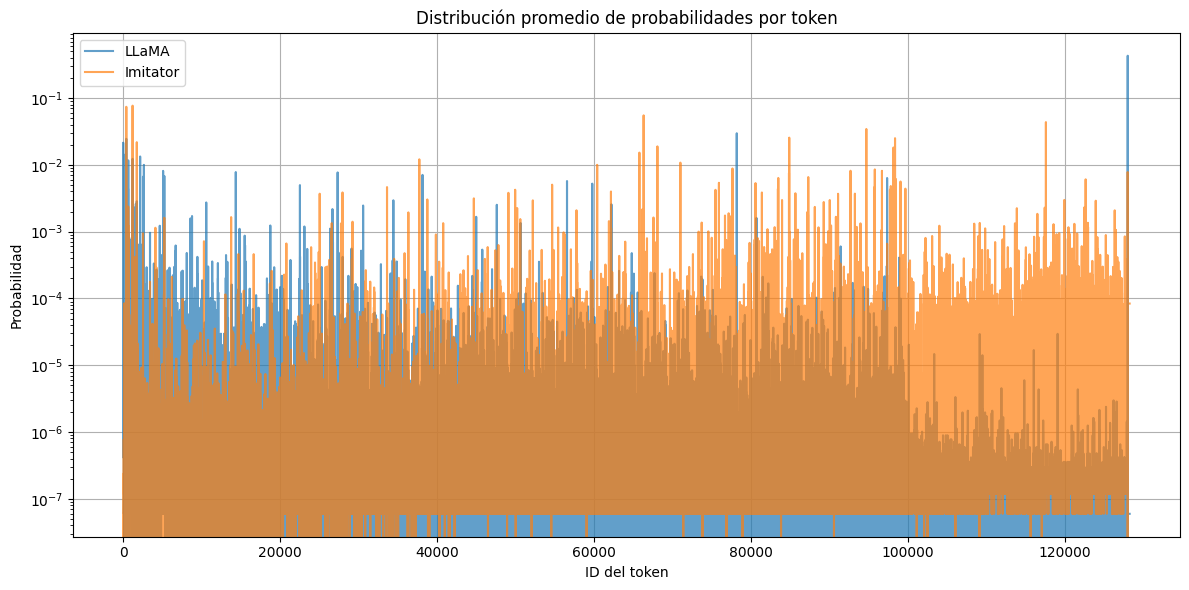

In [63]:
llama_logits = text_logits.squeeze(0).to(dtype=torch.float16)       # [128, vocab_size]
imitator_logits = pred_logits.squeeze(0).to(dtype=torch.float16)     # [128, vocab_size]

llama_probs = F.softmax(llama_logits, dim=-1)       # [128, vocab_size]
imitator_probs = F.softmax(imitator_logits, dim=-1) # [128, vocab_size]

# Promedio a lo largo de los 128 tokens
llama_avg = llama_probs.mean(dim=0).cpu().numpy()       # [vocab_size]
imitator_avg = imitator_probs.mean(dim=0).cpu().numpy() # [vocab_size]

plt.figure(figsize=(12, 6))
plt.plot(llama_avg, label='LLaMA', alpha=0.7)
plt.plot(imitator_avg, label='Imitator', alpha=0.7)
plt.title("Distribución promedio de probabilidades por token")
plt.xlabel("ID del token")
plt.ylabel("Probabilidad")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
print(llama_avg.sum(), imitator_avg.sum())

1.0 1.0


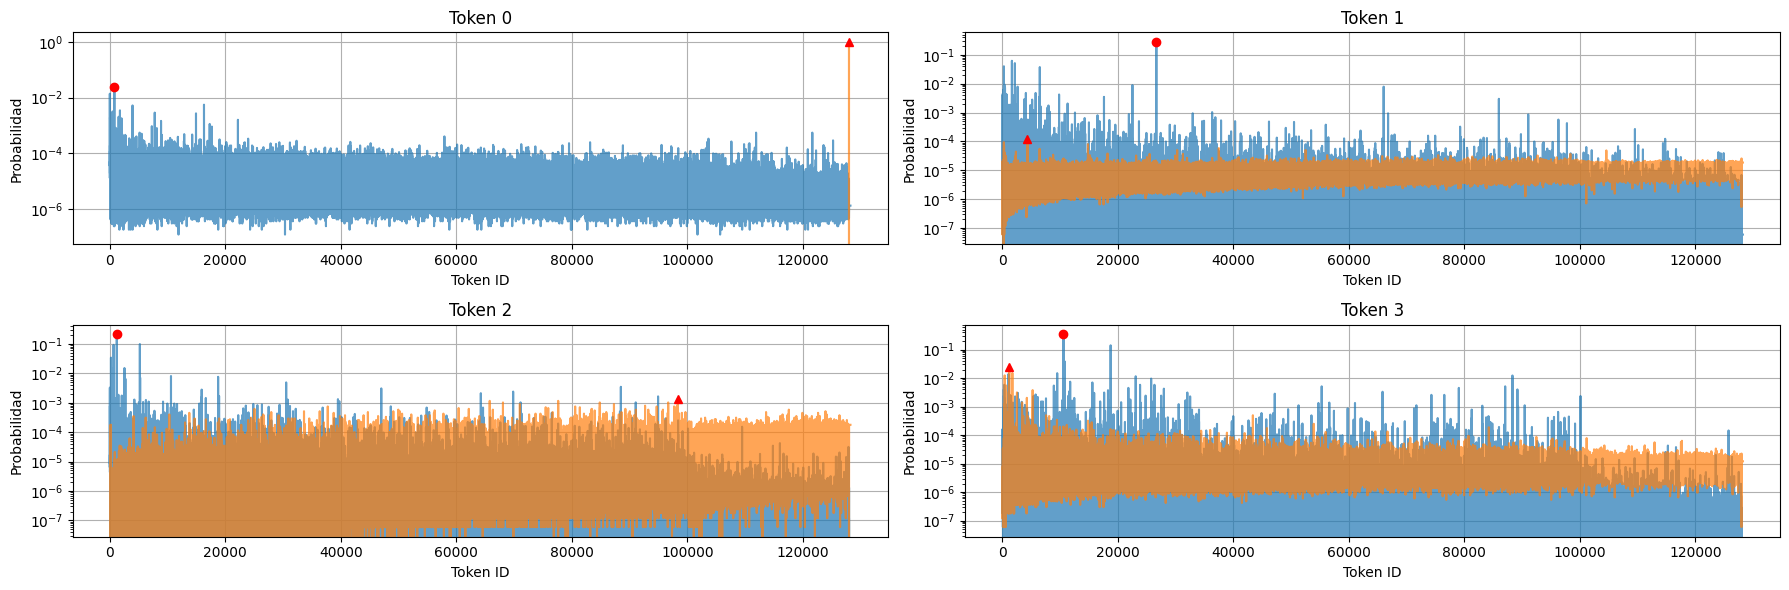

In [65]:
llama_probs = F.softmax(text_logits.squeeze(0).to(dtype=torch.float16), dim=-1)       # [128, vocab_size]
imitator_probs = F.softmax(pred_logits.squeeze(0).to(dtype=torch.float16), dim=-1)     # [128, vocab_size]

n = 4

fig, axes = plt.subplots(2, 2, figsize=(18, 6))
axes = axes.flatten()

for i in range(4):
    lp = llama_probs[i].cpu().numpy()
    ip = imitator_probs[i].cpu().numpy()

    axes[i].plot(lp, label='LLaMA', alpha=0.7)
    axes[i].plot(ip, label='Imitator', alpha=0.7)

    # Índices con mayor probabilidad
    llama_top = lp.argmax()
    imitator_top = ip.argmax()

    axes[i].plot(llama_top, lp[llama_top], 'ro', label='LLaMA max' if i == 0 else "", markersize=6)
    axes[i].plot(imitator_top, ip[imitator_top], 'r^', label='Imitator max' if i == 0 else "", markersize=6)

    axes[i].set_title(f'Token {i}')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('Token ID')
    axes[i].set_ylabel('Probabilidad')
    axes[i].grid(True)

plt.tight_layout()
plt.show()